# Predicting Swiss Hiking Scales Rankings using GPS data logs

In [51]:
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
from zipfile import ZipFile
import os

import seaborn as sns
sns.set_context(context='notebook', font_scale=2)
sns.set_style("darkgrid", {"axes.facecolor": ".9",
                           'xtick.bottom': True,
                           'xtick.top': False,
                           'ytick.left': True,
                           'ytick.right': False, })
from scipy import stats

from sklearn import cluster, neighbors
from sklearn.model_selection import KFold, GridSearchCV, train_test_split
from sklearn.metrics import silhouette_score, confusion_matrix, classification_report, accuracy_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
# %matplotlib inline
# from IPython.core.interactiveshell import InteractiveShell
# InteractiveShell.ast_node_interactivity = "all"
# # Allows for multiple output values


Here we open the zip file with ZipFile and extract the the only name from the string list. We read the csv file using pandas CSV reader 


In [2]:
zip_file_name = 'gpx-hike-tracks.zip'
    # We first read the zip file using a zipfile.ZipFile object.
with ZipFile(zip_file_name) as temp_zip:
    csv_file_name = temp_zip.namelist()[0]
    with temp_zip.open(csv_file_name) as temp_csv:
        hike_df = pd.read_csv(temp_csv)
            

Here we clean up the string values under the difficulty column and add a simplified version without the + and - designation

In [3]:
fixed_label_list = []
simplified_label = []
for string in hike_df['difficulty']:  # cleans up the notation
    name_array = string.split(' ', 1)
    code = f'({name_array[0]}): '
    label = name_array[1].split('- ', 1)[1]
    fixed_label_list.append(code + label)

    simplified_label.append(string[0:2] + ': ' + label)  # removes all + or - notation (simple)
hike_df['difficulty'] = pd.Series(fixed_label_list)
hike_df['difficulty_simple'] = pd.Series(simplified_label)  # adds simple column to data frame

hike_difficulty_list = sorted(set(simplified_label), key=lambda value: int(value[1])) 
# sorts from T1 too T6 using the 1st index from the string

Metric to Imperial Units and fix time units 

In [4]:
try: 
    
    hike_df['length_3d'] /= 1609.344   # convert length_3d from meters to miles
    hike_df.rename(columns={'length_3d':'3D_length_miles'}, inplace=True)

    hike_df['length_2d'] /= 1609.344   # convert length_3d from meters to miles
    hike_df.rename(columns={'length_2d':'2D_length_miles'}, inplace=True)


    hike_df['max_elevation'] *=  3.281 # convert meters to feet
    hike_df.rename(columns ={'max_elevation' : 'max_elevation_feet'}, inplace=True)

    hike_df['min_elevation'] *= 3.281 # convert meters to feet
    hike_df.rename(columns = {'min_elevation' : 'min_elevation_feet'}, inplace=True)
    
    hike_df['max_speed'] *=  (3600 / 1609.34)  # m/s now to miles/hr
    hike_df.rename(columns = {'max_speed' : 'max_speed_mph'}, inplace=True)
    
    hike_df['moving_time'] /= 3600  # seconds to hours
    hike_df.rename(columns = {'moving_time' : 'moving_time_hr'}, inplace=True)
    
    hike_df['uphill'] *=  3.281  # convert uphill from meters to feet
    hike_df.rename(columns = {'uphill': 'uphill_feet'}, inplace=True)
    
    hike_df['downhill'] *=  3.281   # convert downhill from meters to feet
    hike_df.rename(columns = {'downhill' : 'downhill_feet'}, inplace=True)

except KeyError:
    pass


Analysis as to the maximum speed of hikers. 0 MPH,
0 < max_speed <= 1

1 < max_speed <= 2

2 < max_speed <= 3 

etc....
max_speed > n

In [5]:
max_speed_mph = hike_df.loc[:, 'max_speed_mph']
total_size = max_speed_mph.shape[0]


no_speed_size = (max_speed_mph[max_speed_mph == 0 ]).shape[0]

mph_array = list(range(0,8))
# print(mph_array)

mph_dict = {}

for i, speed in enumerate(mph_array):
    if speed == 0:
        mph_dict[speed] = (max_speed_mph[max_speed_mph == speed ]).shape[0]
        
    elif  0 < speed <= (max(mph_array) - 1):
        mph_dict[speed] = (max_speed_mph[(mph_array[i-1] < max_speed_mph) & (max_speed_mph <= speed)]).shape[0]
        
    elif speed >= max(mph_array):
        mph_dict[speed] = (max_speed_mph[max_speed_mph >= speed ]).shape[0]

# print('MPH_BINNING:',mph_dict)


# Bar-plot showing Max MPH of Hikers

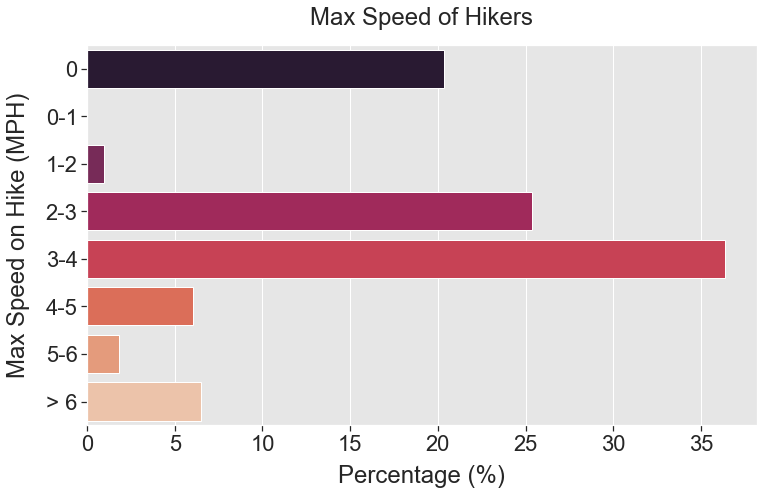

In [6]:
mph_strings = ['0', '0-1', '1-2', '2-3', '3-4', '4-5', '5-6', ' > 6']
mph_percent = np.array(list(mph_dict.values())) / total_size * 100
# mph_percent = (mph_dict.values / total_size) * 100

fig, ax = plt.subplots(ncols=1, figsize=(12, 7))
ax = sns.barplot(mph_percent,mph_strings,palette="rocket")
plt.title("Max Speed of Hikers", pad=20);
plt.xlabel('Percentage (%)', labelpad=10);
plt.ylabel('Max Speed on Hike (MPH)',labelpad=10);
plt.savefig('max_speed_hikers.pdf', bbox_inches="tight")
plt.show()

# Remove data with max speed > 6 MPH
hike_df = hike_df[hike_df['max_speed_mph'] < 6]


Hikers with a max speed over 6 MPH makes their data suspicious while hikers with a max speed of 0 must be due to either not being reported or not calculated. 

Data with max speed > 6 MPH is removed from dataframe as it only encomposes less than 10% of the entire data and is unrealistic.

# Hiking frequency Plot 
Hiking Length of 0 Miles makes no sense, Data must be cleaned again

In [7]:
# Remove hikes with 2D length of 0 miles
hike_df = hike_df[hike_df['2D_length_miles'] > 0]

## Find the length of hikes that encompasses > 99 %

In [8]:
x = hike_df['2D_length_miles']

# Manual Quantile
for i in range(x.shape[0]):
    
    subset = (x[x < i+1]).shape[0]
    percent_of_data = subset / x.shape[0]
    if  percent_of_data < .99:
        pass
    else:
        length_cutoff = i+1
        break
        
# Fast Quantile 
length_cutoff_fast = np.ceil(x.quantile(q=0.99))
        
print(f'99% of the hikes are less than {length_cutoff} miles long')

99% of the hikes are less than 26 miles long


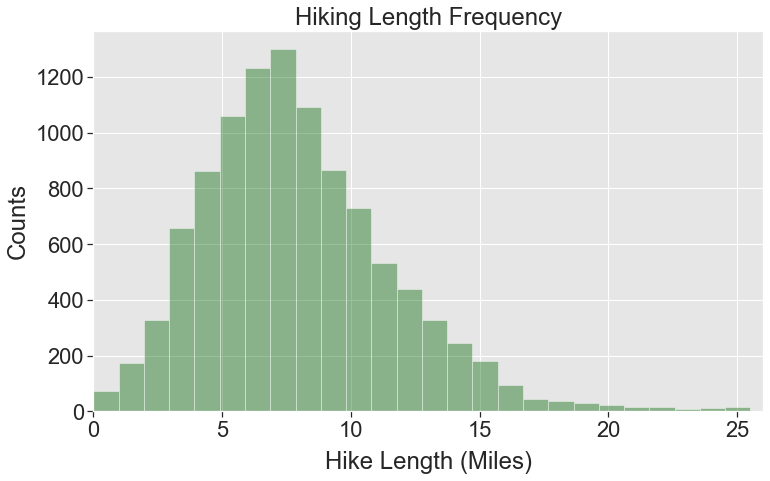

In [9]:
fig, ax = plt.subplots(ncols=1, figsize=(12, 7))


ax = sns.distplot(x[x < length_cutoff], bins=length_cutoff, kde=False,  color="darkgreen")
ax.set_xlim((0, length_cutoff))
ax.set_xlabel('Hike Length (Miles)', labelpad=10)
ax.set_ylabel('Counts', labelpad=5)
ax.set_title('Hiking Length Frequency')
plt.savefig('hike_length_density.pdf', bbox_inches='tight')
plt.show()

C:\Users\adamc\Anaconda3\envs\Competition_Project\lib\site-packages\scipy\stats\_distn_infrastructure.py:2407: RuntimeWarning: invalid value encountered in double_scalars
  Lhat = muhat - Shat*mu


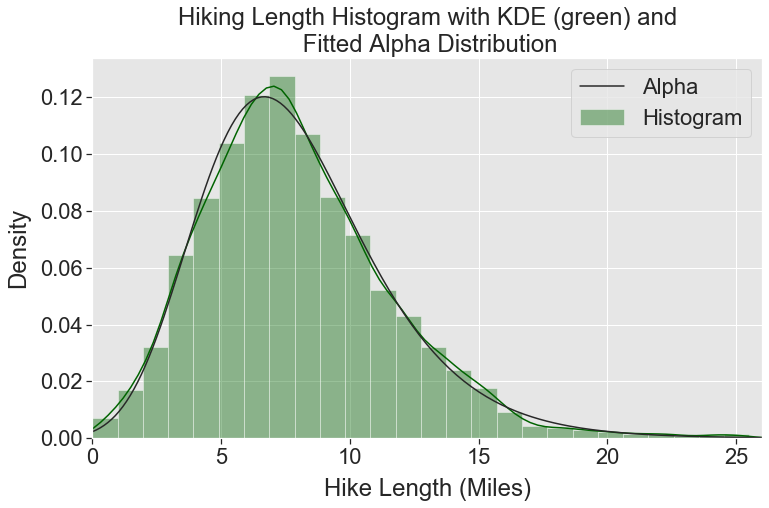

In [10]:
fig, ax = plt.subplots(ncols=1, figsize=(12, 7))
ax = sns.distplot(x[x < length_cutoff], bins=26, kde=True, color="darkgreen", fit=stats.alpha)
ax.set_xlim((0, length_cutoff))
ax.set_xlabel('Hike Length (Miles)', labelpad=10)
ax.set_ylabel('Density', labelpad=10)
ax.set_title('Hiking Length Histogram with KDE (green) and\n Fitted Alpha Distribution')
plt.savefig('hike_length_density.pdf', bbox_inches='tight')
plt.legend(['Alpha','Histogram'])
plt.show()

### Remove hikes longer than 26 miles

In [11]:
hike_df = hike_df[hike_df['2D_length_miles'] <= 26]

### Let's Look at Active Hiking Time

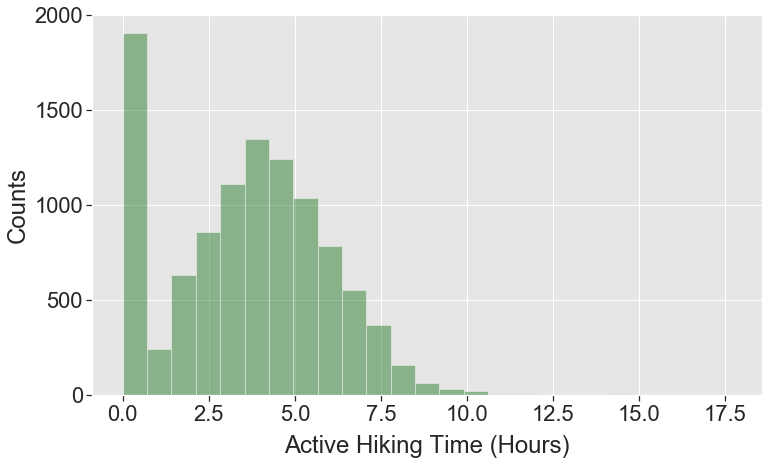

In [12]:
fig, ax = plt.subplots(ncols=1, figsize=(12, 7))
# hike_df[hike_df['moving_time_hr'] > 0]['moving_time_hr'].hist(bins=20)
sns.distplot(hike_df['moving_time_hr'],bins=25, kde=False, color="darkgreen")
plt.xlabel("Active Hiking Time (Hours)", labelpad=10);
plt.ylabel('Counts');

### Remove Active Hiking times of 0 hours

In [13]:
hike_df = hike_df[hike_df['moving_time_hr'] > 0]

Data points where Active Hiking time = 0 hours: 0
Maximum Active Hiking time = 17.69 hours


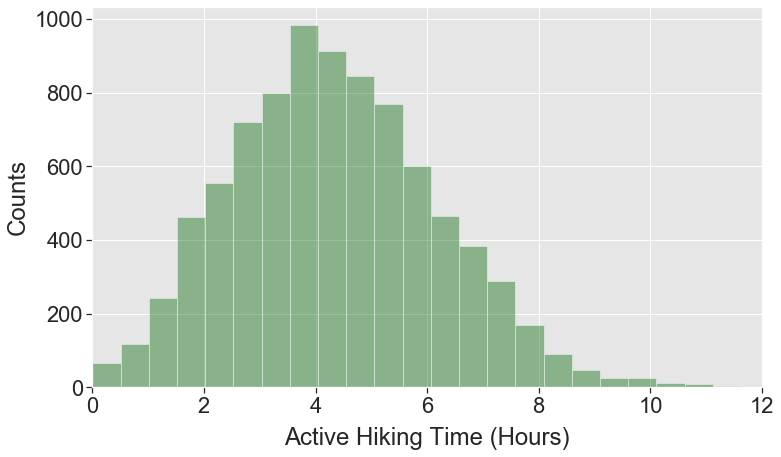

In [14]:
fig, ax = plt.subplots(ncols=1, figsize=(12, 7))
# hike_df[hike_df['moving_time_hr'] > 0]['moving_time_hr'].hist(bins=20)
sns.distplot(hike_df['moving_time_hr'],bins=35, kde=False, color="darkgreen")
plt.xlabel("Active Hiking Time (Hours)", labelpad=10);
plt.ylabel('Counts');
plt.xlim([0, 12])

print('Data points where Active Hiking time = 0 hours:',hike_df[hike_df['moving_time_hr'] == 0].shape[0])
print('Maximum Active Hiking time =', round(hike_df['moving_time_hr'].max(),2), 'hours')

### Remove ascent that is less than 0 feet and ascent for quantiles greater than 99% (false data)! 

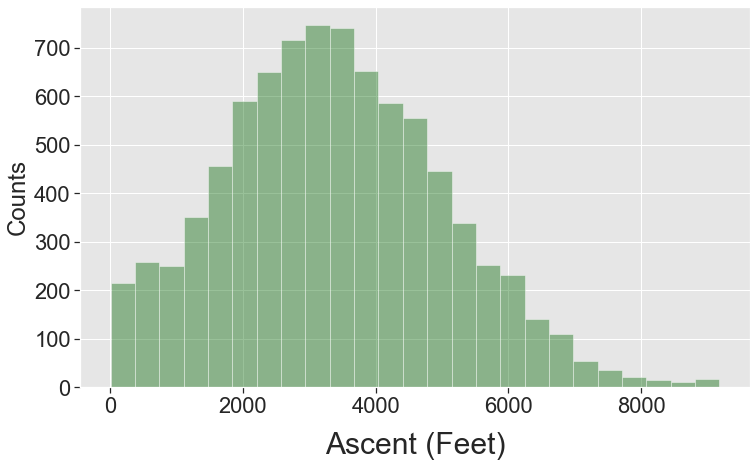

In [15]:
hike_df = hike_df[hike_df['uphill_feet'] > 0]
ascent_threshold = hike_df['uphill_feet'].quantile(q=.99)
hike_df = hike_df[hike_df['uphill_feet'] <= ascent_threshold]
fig, ax = plt.subplots(ncols=1, figsize=(12, 7))

# hike_df[hike_df['moving_time_hr'] > 0]['moving_time_hr'].hist(bins=20)
sns.distplot(hike_df['uphill_feet'],bins=25, kde=False, color="darkgreen")
plt.xlabel('Ascent (Feet)', labelpad=15, fontsize=30);
plt.ylabel('Counts');

In [16]:
minimial_df = hike_df[['2D_length_miles', 'moving_time_hr', 'uphill_feet', 'difficulty_simple']].sort_values(['difficulty_simple'])

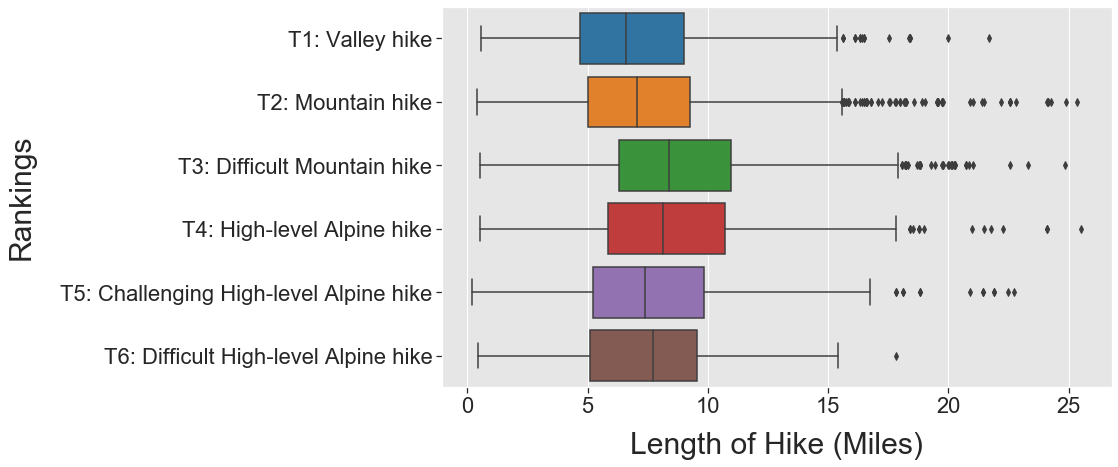

In [17]:
fig, ax = plt.subplots(ncols=1, figsize=(12, 7))
sns.boxplot(x='2D_length_miles', y='difficulty_simple', data=minimial_df)
plt.xlabel('Length of Hike (Miles)', labelpad=15, fontsize=30);
plt.ylabel('Rankings', labelpad=25, fontsize=30);

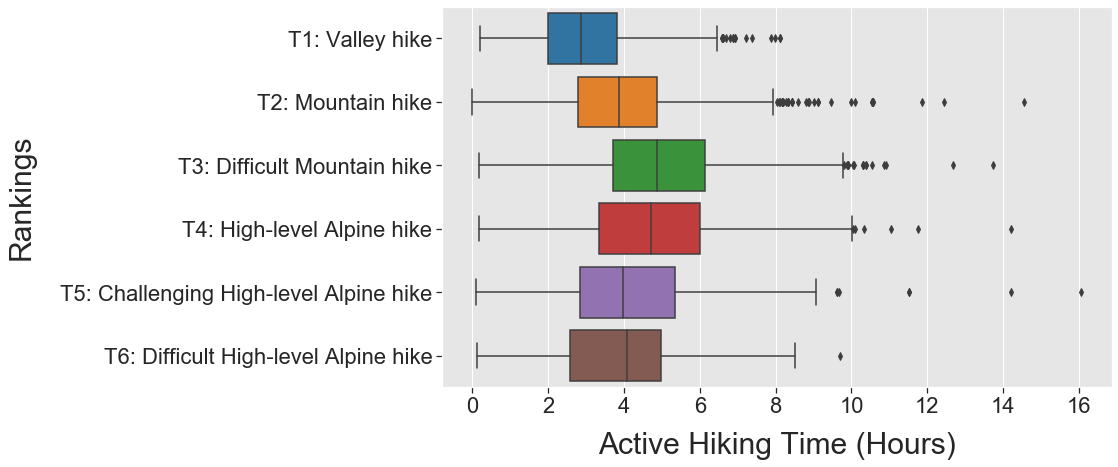

In [18]:
fig, ax = plt.subplots(ncols=1, figsize=(12, 7))
sns.boxplot(x='moving_time_hr', y='difficulty_simple', data=minimial_df)
plt.xlabel('Active Hiking Time (Hours)', labelpad=15, fontsize=30);
plt.ylabel('Rankings', labelpad=25, fontsize=30);

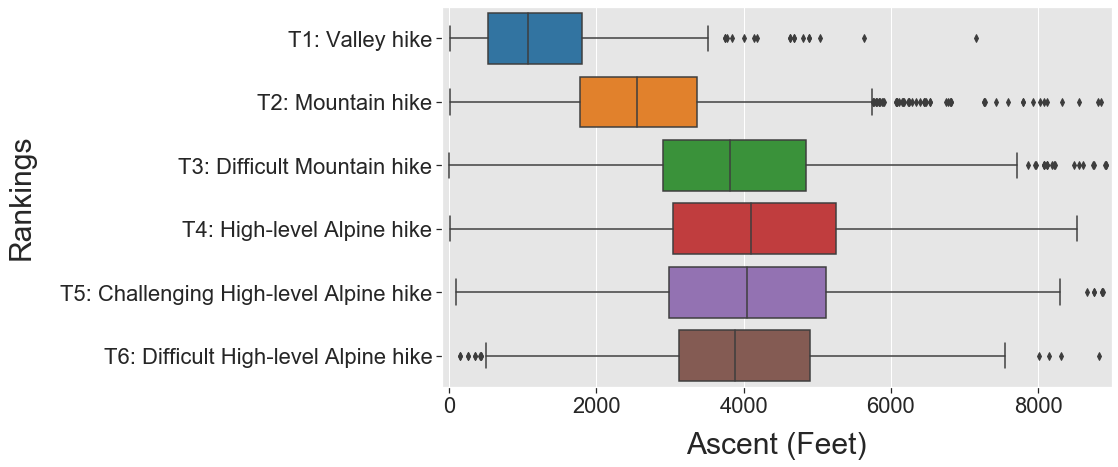

In [148]:
fig, ax = plt.subplots(ncols=1, figsize=(12, 7))
sns.boxplot(x='uphill_feet', y='difficulty_simple', data=minimial_df)
plt.xlabel('Ascent (Feet)', labelpad=15, fontsize=30);
plt.ylabel('Rankings', labelpad=25, fontsize=30);
plt.xlim([-100, 9000]);

In [20]:
minimial_df[(minimial_df.difficulty_simple == 'T1: Valley hike') & (minimial_df.uphill_feet > 4000)]['2D_length_miles'] / minimial_df[(minimial_df.difficulty_simple == 'T1: Valley hike') & (minimial_df.uphill_feet > 4000)]['moving_time_hr']

2367     1.984266
1208     1.939156
7583     1.785418
6229     1.984266
6093     1.592684
6088     2.354404
6440     1.755933
6375     1.568380
2224     2.354404
11082    5.144229
3111     2.778309
3668     1.785418
9777     2.968733
dtype: float64

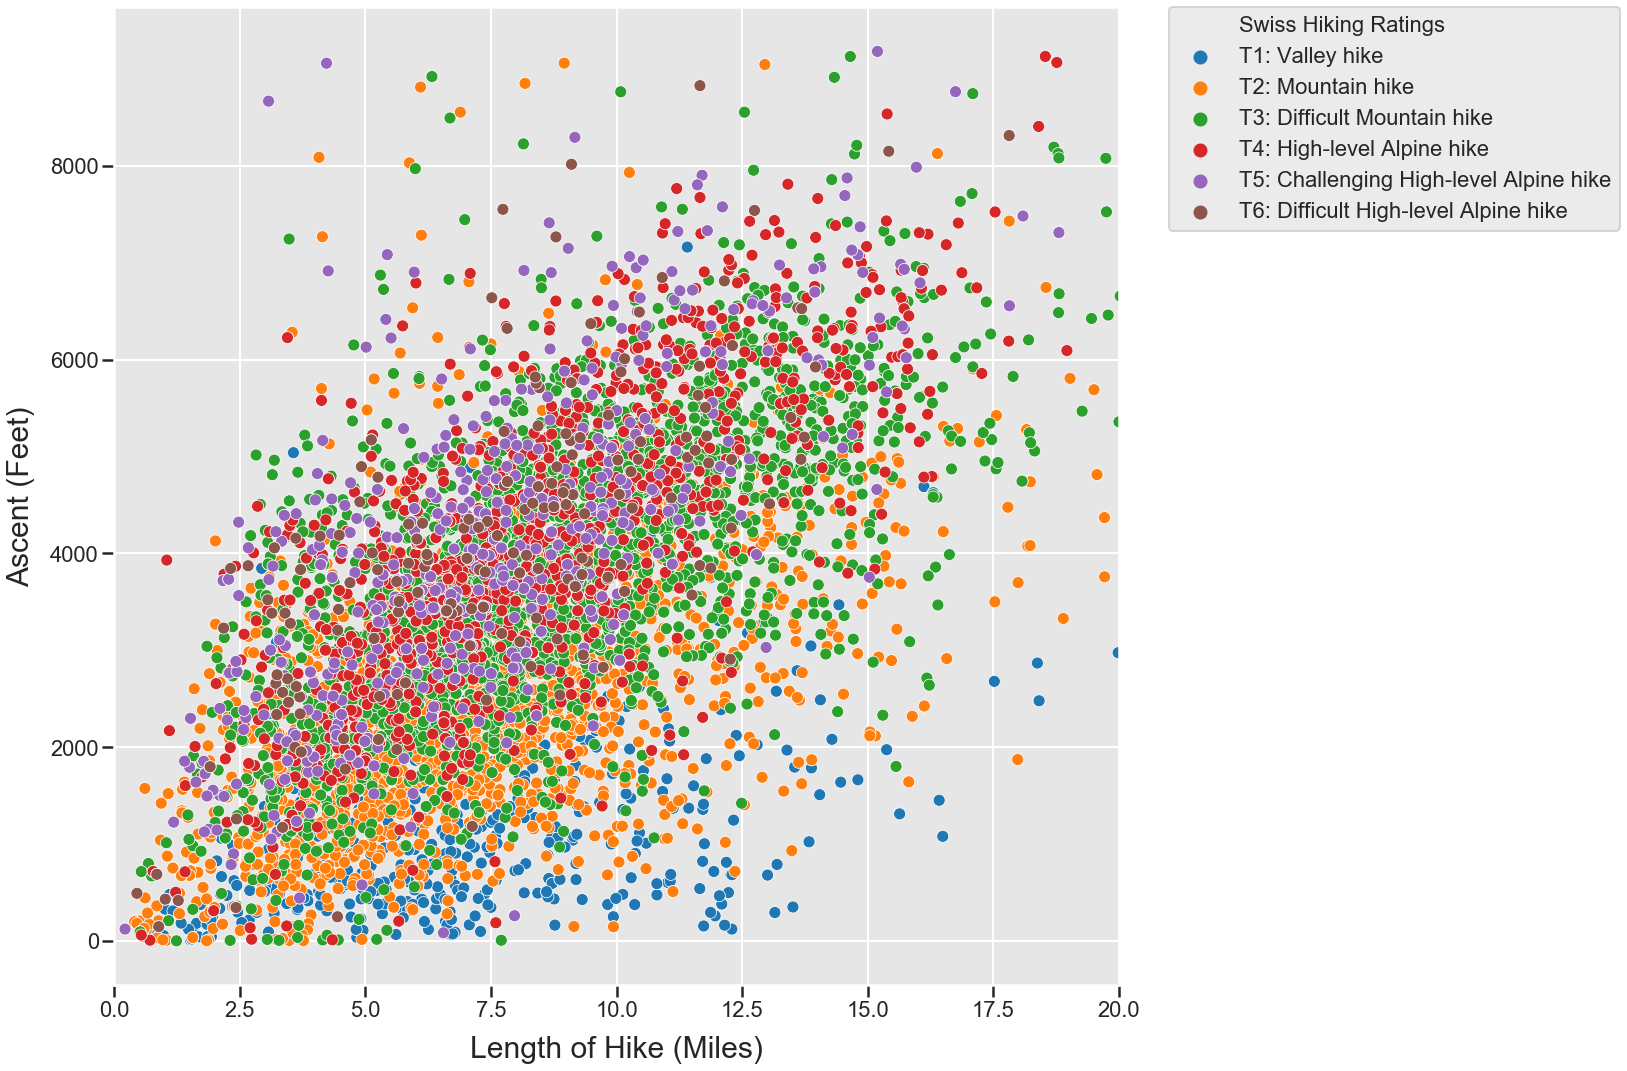

In [21]:
with sns.plotting_context('poster'):
    fig, ax = plt.subplots(ncols=1, figsize=(18, 18))
    sns.scatterplot(x='2D_length_miles', y='uphill_feet', hue='difficulty_simple',  data=minimial_df, ax=ax,)
    plt.ylabel('Ascent (Feet)', labelpad=15, fontsize=30);
    plt.xlabel('Length of Hike (Miles)', labelpad=15, fontsize=30);
    plt.xlim([0, 20])
    handles, labels = ax.get_legend_handles_labels();  # plot legend though from newest to oldest
    labels[0] = 'Swiss Hiking Ratings'
    ax.legend(handles, labels, bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)


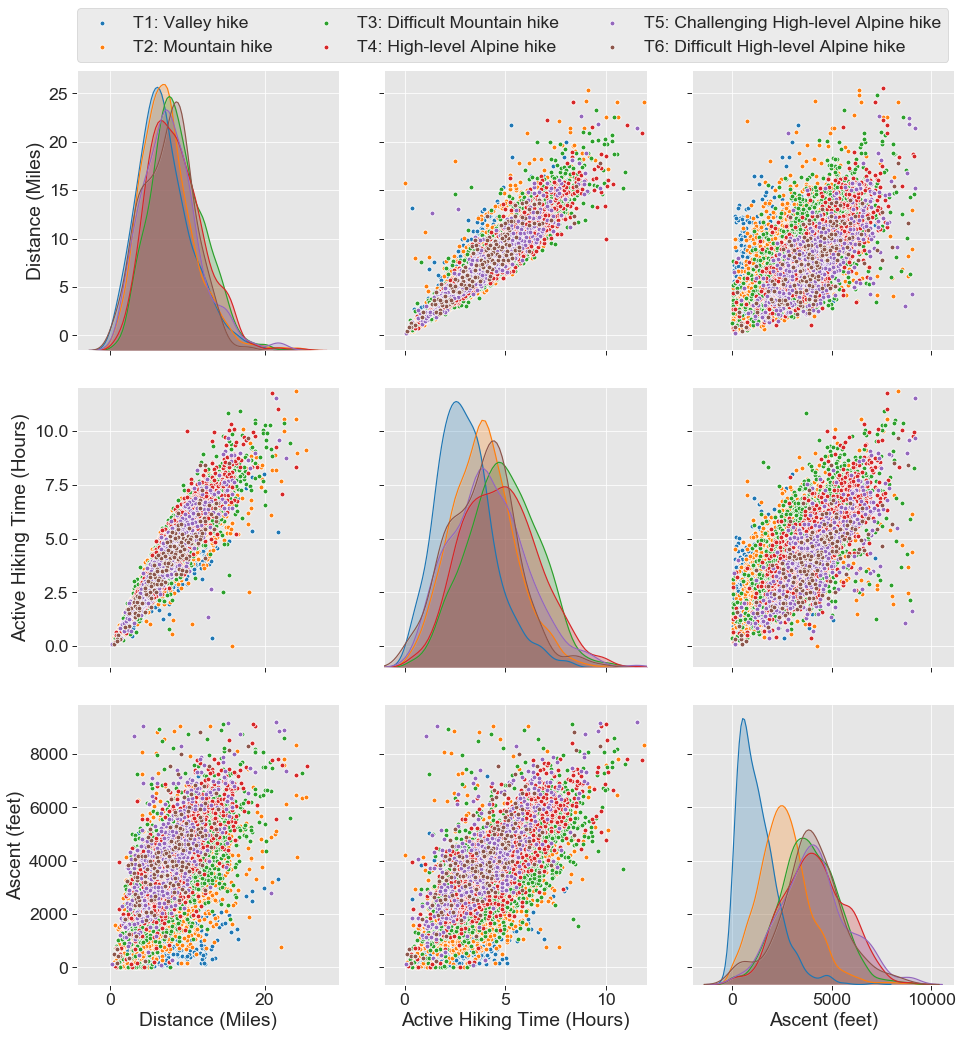

In [22]:
with sns.plotting_context('paper', font_scale=2):
    g = sns.pairplot(minimial_df , hue="difficulty_simple")
    replacements = {'2D_length_miles': 'Distance (Miles)', "moving_time_hr": 'Active Hiking Time (Hours)', "uphill_feet": 'Ascent (feet)'}
    for i in range(3):
        for j in range(3):
            xlabel = g.axes[i][j].get_xlabel()
            ylabel = g.axes[i][j].get_ylabel()
            if xlabel in replacements.keys():
                g.axes[i][j].set_xlabel(replacements[xlabel])
            if ylabel in replacements.keys():
                g.axes[i][j].set_ylabel(replacements[ylabel])
                
    for i in range(3):
        for j in range(3):
            if j==1:
                g.axes[i][j].set_xlim(-1, 12)
            if i==1:
                g.axes[i][j].set_ylim(-1, 12)
                
    g._legend.remove()

    g.fig.set_size_inches(25,15)

    g._legend.set_title("Swiss Hiking Ratings")
    handles = g._legend_data.values()
    labels = g._legend_data.keys()
    g.fig.legend(handles=handles, labels=labels, loc=(0.08, 0.94), borderaxespad=0, ncol=3)
    g.fig.subplots_adjust(top=0.93)

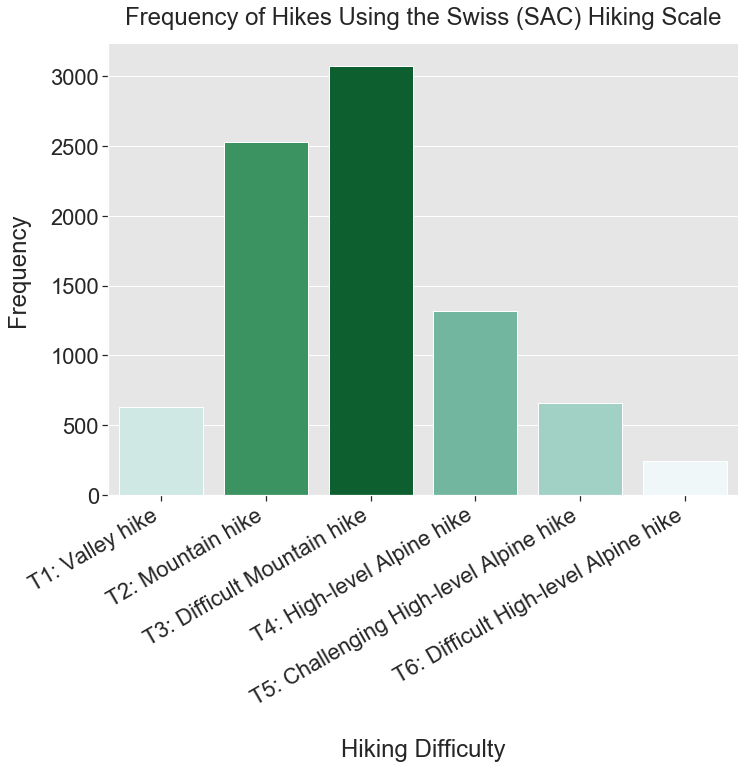

,difficulty count,hiking_colors,code
T1: Valley hike,628,#ccece6,1
T2: Mountain hike,2528,#2ca25f,2
T3: Difficult Mountain hike,3075,#006d2c,3
T4: High-level Alpine hike,1315,#66c2a4,4
T5: Challenging High-level Alpine hike,657,#99d8c9,5
T6: Difficult High-level Alpine hike,240,#edf8fb,6


In [149]:
difficulty_series = hike_df['difficulty_simple'].value_counts()  # retrieves which hikes were most popular
ranked_values = pd.Series.tolist(difficulty_series)  # convert to a list

hiking_colors = ['#edf8fb',  # lightest green
                 '#ccece6',
                 '#99d8c9',
                 '#66c2a4',
                 '#2ca25f',
                 '#006d2c'  # darkest green
                 ]
hiking_colors = [x for _, x in sorted(zip(ranked_values, hiking_colors))] 
# sorts colors by ranked values, now lighted color for smallest value

color_df = pd.DataFrame(ranked_values, columns=['difficulty count'], index=difficulty_series.index)
color_df['hiking_colors'] = hiking_colors
color_df['code'] = [code[1] for code in difficulty_series.index]
color_df = color_df.sort_values(by=['code'], ascending=True)

ax = sns.catplot(x='difficulty_simple', kind='count', data=hike_df, orient="v", height=8.27,
                 aspect=11.7 / 8.27, order=hike_difficulty_list, palette=color_df['hiking_colors'])
ax.fig.autofmt_xdate()
plt.xlabel('Hiking Difficulty', labelpad=30)
plt.ylabel('Frequency', labelpad=20)
plt.title("Frequency of Hikes Using the Swiss (SAC) Hiking Scale", pad=20)
plt.savefig('diff_vs_freq.pdf', bbox_inches="tight")
plt.show()

color_df  # show table

## Unsupervised Clustering

In [24]:
cluster_sizes = np.arange(2,6)
sil_scores = {}


for n in cluster_sizes:
    cls_hike = cluster.KMeans(n_clusters=n)
    cls_hike.fit(minimial_df[['uphill_feet', '2D_length_miles', 'moving_time_hr']])
    sil_score = silhouette_score(minimial_df[['uphill_feet', '2D_length_miles', 'moving_time_hr']], cls_hike.labels_)
    print(f'n={n} ->', sil_score)
    sil_scores[f'n={n}']=sil_score

n=2 -> 0.5588315239478621
n=3 -> 0.5331145346623072
n=4 -> 0.5293013452505516
n=5 -> 0.5332625251287247


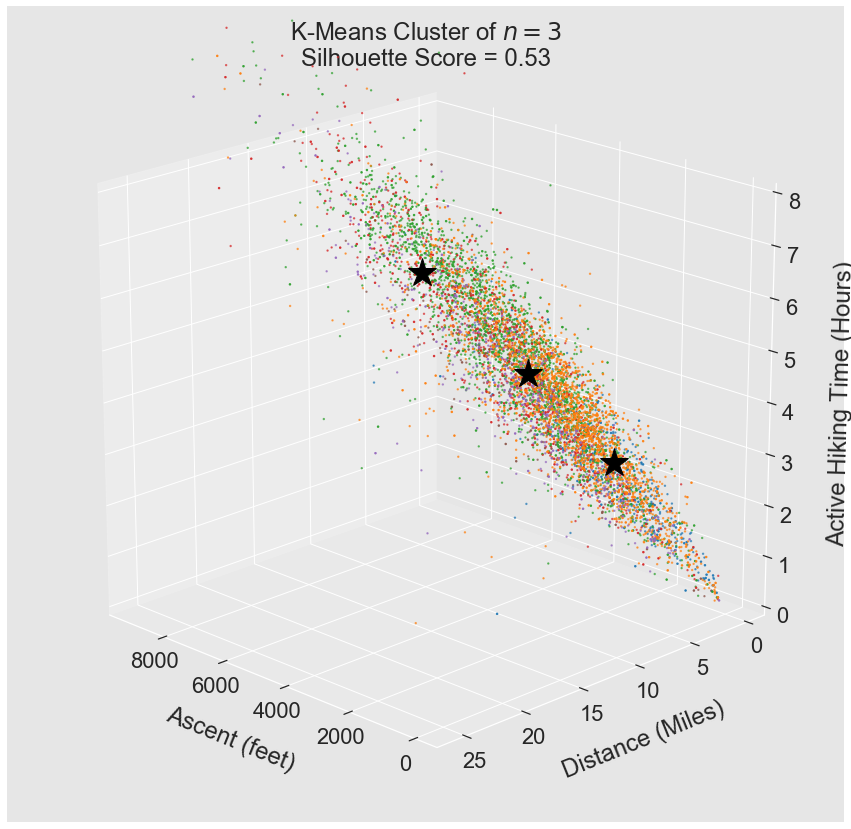

In [25]:
cls_hike = cluster.KMeans(n_clusters=3)
cls_hike.fit(minimial_df[['uphill_feet', '2D_length_miles', 'moving_time_hr']])

from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.view_init(elev=20, azim=135)

unique_classes = minimial_df.difficulty_simple.unique()
for i in range(6):
    temp_df = minimial_df[minimial_df.difficulty_simple == unique_classes[i]]
    ax.scatter(temp_df['uphill_feet'], temp_df['2D_length_miles'], temp_df['moving_time_hr'], marker='o', s=2, alpha=0.6,zorder=-i )
fig.set_size_inches(15,15)
ax.set_xlabel('Ascent (feet)', labelpad=25);
ax.set_ylabel('Distance (Miles)', labelpad=25);
ax.set_zlabel('Active Hiking Time (Hours)', labelpad=25);
ax.set_zlim([0, 8]);
# ax.scatter(cls_hike.cluster_centers_[:,0], cls_hike.cluster_centers_[:,1], cls_hike.cluster_centers_[:,2], marker='*', s=900, alpha=1, c='k', zorder=-10000)
ax.plot(cls_hike.cluster_centers_[:,0], cls_hike.cluster_centers_[:,1], cls_hike.cluster_centers_[:,2], '*', markersize=30,
        lw=0, color='k', zorder=100)
plt.title(r'K-Means Cluster of $n=3$' + '\n' + f'Silhouette Score = {sil_score:.2f}');

# Classification Models


In [26]:
my_LE = LabelEncoder()
my_LE.fit(minimial_df.difficulty_simple)
y = my_LE.transform(minimial_df.difficulty_simple)

In [43]:
X_TRAIN, X_TEST, Y_TRAIN, Y_TEST = train_test_split(minimial_df[['uphill_feet', '2D_length_miles', 'moving_time_hr']], y)

KF = KFold(n_splits=5, shuffle=True)
k_neighbors = list(range(1,7,2))
k_neighbors

n_grid = [{'n_neighbors': k_neighbors}]
model_k_neigh = neighbors.KNeighborsClassifier(weights='uniform',  leaf_size=30)

cv_knn = GridSearchCV(estimator=model_k_neigh, param_grid=n_grid, cv=KF, verbose=1)
cv_knn.fit(X=X_TRAIN,y=Y_TRAIN)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    0.6s finished


GridSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=True),
             error_score=nan,
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid='deprecated', n_jobs=None,
             param_grid=[{'n_neighbors': [1, 3, 5]}], pre_dispatch='2*n_jobs',
             refit=True, return_train_score=False, scoring=None, verbose=1)

In [44]:
cv_knn.best_params_

{'n_neighbors': 1}

In [45]:
knnclf = neighbors.KNeighborsClassifier(n_neighbors=cv_knn.best_params_['n_neighbors'])
knnclf.fit(X_TRAIN, Y_TRAIN)
y_pred = knnclf.predict(X_TEST)
confusion_matrix(Y_TEST, y_pred)

array([[ 94,  40,  12,   5,   3,   0],
       [ 42, 354, 131,  49,  17,   8],
       [  9, 129, 509,  86,  62,  12],
       [  4,  37,  95, 157,  24,   3],
       [  1,  20,  42,  28,  77,   1],
       [  1,   5,  18,   7,   1,  28]], dtype=int64)

In [48]:
print ('Accuracy Score :',accuracy_score(Y_TEST, y_pred))

Accuracy Score : 0.5774514448128849


Classification Reportcard Using K-nearest Neighbors Classification

In [146]:
# inverse transform the numerical classifications to labels
print(classification_report(my_LE.inverse_transform(Y_TEST), my_LE.inverse_transform(y_pred)))

                                        precision    recall  f1-score   support

                       T1: Valley hike       0.62      0.61      0.62       154
                     T2: Mountain hike       0.61      0.59      0.60       601
           T3: Difficult Mountain hike       0.63      0.63      0.63       807
            T4: High-level Alpine hike       0.47      0.49      0.48       320
T5: Challenging High-level Alpine hike       0.42      0.46      0.44       169
  T6: Difficult High-level Alpine hike       0.54      0.47      0.50        60

                              accuracy                           0.58      2111
                             macro avg       0.55      0.54      0.54      2111
                          weighted avg       0.58      0.58      0.58      2111



# Let's standardize the dataset and use PCA

In [75]:
n_comp = 3
hike_PCA = PCA(n_components=n_comp)
hike_PCA.fit_transform(X_TRAIN);

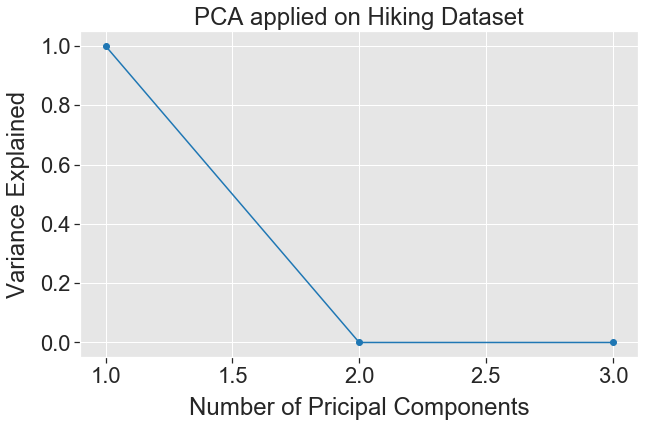

In [95]:
hike_COVAR = hike_PCA.get_covariance()
fig, axe = plt.subplots(figsize=(10, 6))
x_pca = np.arange(1, 3+1)
y_pca = hike_PCA.explained_variance_ratio_
plt.plot(x_pca, y_pca, marker ='o');
plt.xlabel('Number of Pricipal Components', labelpad=10);
plt.ylabel('Variance Explained', labelpad=10);
plt.title('PCA applied on Hiking Dataset');

In [135]:
pipe = make_pipeline(StandardScaler(), PCA(n_components=1), neighbors.KNeighborsClassifier(weights='uniform',  leaf_size=30))

n_comp = [1, 2, 3] # number of components to try
pipe  # visually see the data pipeline

Pipeline(memory=None,
         steps=[('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('pca',
                 PCA(copy=True, iterated_power='auto', n_components=1,
                     random_state=None, svd_solver='auto', tol=0.0,
                     whiten=False)),
                ('kneighborsclassifier',
                 KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                      metric='minkowski', metric_params=None,
                                      n_jobs=None, n_neighbors=5, p=2,
                                      weights='uniform'))],
         verbose=False)

In [129]:
print(pipe.get_params().keys())  # get keys

dict_keys(['memory', 'steps', 'verbose', 'standardscaler', 'pca', 'kneighborsclassifier', 'standardscaler__copy', 'standardscaler__with_mean', 'standardscaler__with_std', 'pca__copy', 'pca__iterated_power', 'pca__n_components', 'pca__random_state', 'pca__svd_solver', 'pca__tol', 'pca__whiten', 'kneighborsclassifier__algorithm', 'kneighborsclassifier__leaf_size', 'kneighborsclassifier__metric', 'kneighborsclassifier__metric_params', 'kneighborsclassifier__n_jobs', 'kneighborsclassifier__n_neighbors', 'kneighborsclassifier__p', 'kneighborsclassifier__weights'])


In [130]:
PCA_grid = [{'pca__n_components':n_comp, 'kneighborsclassifier__n_neighbors': k_neighbors}]

In [136]:
hiker_cls = GridSearchCV(estimator=pipe, param_grid=PCA_grid, cv=KF, verbose=1)
hiker_cls.fit(X_TRAIN, Y_TRAIN)
hiker_cls.best_params_

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    1.3s finished


{'kneighborsclassifier__n_neighbors': 1, 'pca__n_components': 2}

In [145]:
Y_PCA_STAND = hiker_cls.predict(X_TEST)

print('Confusion Matrix:\n' ,confusion_matrix(Y_TEST, Y_PCA_STAND))
print()
print ('Accuracy Score :',accuracy_score(Y_TEST, Y_PCA_STAND))
print()
print(classification_report(my_LE.inverse_transform(Y_TEST), my_LE.inverse_transform(Y_PCA_STAND)))

Confusion Matrix:
 [[102  35  10   5   2   0]
 [ 41 362 123  48  18   9]
 [ 16 150 502  92  31  16]
 [  2  46  81 167  14  10]
 [  1  16  44  24  76   8]
 [  0   4  13   5   7  31]]

Accuracy Score : 0.5873993368072004

                                        precision    recall  f1-score   support

                       T1: Valley hike       0.63      0.66      0.65       154
                     T2: Mountain hike       0.59      0.60      0.60       601
           T3: Difficult Mountain hike       0.65      0.62      0.64       807
            T4: High-level Alpine hike       0.49      0.52      0.51       320
T5: Challenging High-level Alpine hike       0.51      0.45      0.48       169
  T6: Difficult High-level Alpine hike       0.42      0.52      0.46        60

                              accuracy                           0.59      2111
                             macro avg       0.55      0.56      0.55      2111
                          weighted avg       0.59      0.5

In [158]:
performance_increase = (accuracy_score(Y_TEST, Y_PCA_STAND)  - accuracy_score(Y_TEST, y_pred)) * 100
print(f"Standardizing with PCA increased the peformance by: {performance_increase:.2f} %")

Standardizing with PCA increased the peformance by: 0.99 %
